In [1]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


# Chemical cost structure of the BNF paragraphs via PCA

This notebook looks at spend on each BNF paragraph using prinicipal component analysis (PCA) in order to

- gauge the "complexity" of the cost structure of the paragraphs through "explained variation". The fewer components needed to explain a good fraction of the paragraphs variance, the simpler its cost structure.
- gain insight into the concrete combinations of chemicals that are most aligned with the cost variation in each paragraphs

## BigQuery

For this analysis, we need costs for each (chemical, CCG) pair: quite a large result set.

In [2]:
df=gbq.query(
    '''
    select BNF_CHEMICAL,PCT,sum(ACT_COST) TOTAL_ACT_COST
    from [nhs.PDPI2]
    where PERIOD contains "2015"
    group by BNF_CHEMICAL, PCT
    ''',
    max_rows=500000,
    index=['BNF_CHEMICAL','PCT'],cast={'TOTAL_ACT_COST':float},
    cachedir='/tmp/gbq'
)

Reading cached results from /tmp/gbq/42c0b627b5d645728652864c4610f7cf.json
375817 rows converted to DataFrame in 0.88 seconds


In [3]:
df.head()

,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
1310012F0,10V,5296.77
1310020A0,10V,4703.82
210109005,10V,15729.46
225010050,10V,50380.00
0107020J0,10V,15981.07


## CCG segmentation

Again the CCGs form two clusters. Let's keep only the cluster of CCGs prescribing the broader set of chemicals.

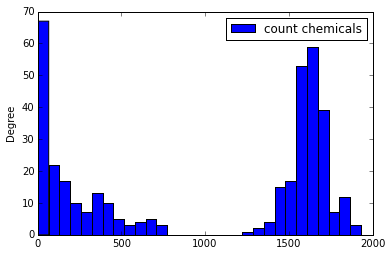

In [4]:
df.groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'}).plot(kind='hist',bins=30)

In [5]:
chemsperccg=df.groupby(level=1).count()
chemsperccg
ccgskeep=set(chemsperccg[chemsperccg['TOTAL_ACT_COST']>1000].index)
len(ccgskeep)

212

Let's apply this restriction to the main dataframe and map the CCG ids to names for readability.

In [6]:
dfkeep=df[df.index.map(lambda i:i[1] in ccgskeep and i[1] in ccg.ccgs())]
print "(chemical,ccg pairs) remaining:",len(dfkeep)
dfkeep.head()

(chemical,ccg pairs) remaining: 343942


,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
1310012F0,10V,5296.77
1310020A0,10V,4703.82
210109005,10V,15729.46
225010050,10V,50380.00
0107020J0,10V,15981.07


## CCG-paragraph level aggregation

Let's compute the fractional cost of each chemical inside a (CCG,paragraphs) pair.

First, let's add the paragraphs into the dataframes index (as first 6 chars of BNF chemical code).

While we're at it, let's also decode the CCG ids to names.

In [7]:
dfkeep.index=pd.MultiIndex.from_tuples(dfkeep.index.map(lambda i: (i[0],
                                                                   "%s (%s)" % (bnf.path(i[0][:6])[-1],i[0][:6]),
                                                                   ccg.name(i[1])
                                                                  )))
dfkeep.index.set_names(['BNF_CHEMICAL','BNF_PARAGRAPH','CCG'],inplace=True)
dfkeep.head()

,,,TOTAL_ACT_COST
BNF_CHEMICAL,BNF_PARAGRAPH,CCG,
1310012F0,Antibacterial Preparations (131001),NHS SOUTH EASTERN HAMPSHIRE CCG,5296.77
1310020A0,Antifungal Preparations (131002),NHS SOUTH EASTERN HAMPSHIRE CCG,4703.82
210109005,Other Appliances (210109),NHS SOUTH EASTERN HAMPSHIRE CCG,15729.46
225010050,Leg Bags (225010),NHS SOUTH EASTERN HAMPSHIRE CCG,50380.00
0107020J0,Co Haemorrhoidal Prep's + Corticosteroid (010702),NHS SOUTH EASTERN HAMPSHIRE CCG,15981.07


### Some paragraphs are too thin for this analysis

It's worth checking to see how many distinct chemicals are described from each paragraph.

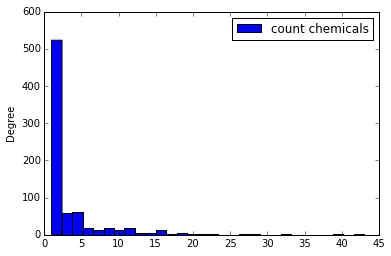

In [8]:
chemicalsperpara=dfkeep.groupby(level=[0,1]).sum().groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'})
chemicalsperpara.plot(kind='hist',bins=30)

Some paragraphs have a tiny number of chemicals being prescribed so let's exclude them, and take only those with more than 15.

In [9]:
broadparas=set(chemicalsperpara[chemicalsperpara['count chemicals']>15].index)
dfkeep2=dfkeep[dfkeep.index.map(lambda i: i[1] in broadparas)]
# I had to rebuild index here; otherwise it was keeping hold of unwanted entries (index entries with no rows). Not sure why...
# Independently noted here: http://stackoverflow.com/questions/30941425/updating-pandas-multiindex-after-indexing-the-dataframe
dfkeep2=dfkeep2.reset_index().set_index(['BNF_CHEMICAL','BNF_PARAGRAPH','CCG'])

In [10]:
len(broadparas)

23

### Actually compute the fractions

This is a one-liner using pandas (though not the most obvious...)

In [11]:
# need to work around pandas limitation for joining across multiple index columns
fracs=dfkeep2.unstack(0).div(dfkeep2.groupby(level=[1,2]).sum().squeeze(),axis=0).stack()
fracs.columns=['FRAC_CCG_PARAGRAPH_COST']
fracs.index=fracs.index.swaplevel(1,2)
fracs.head()

FRAC_CCG_PARAGRAPH_COST
BNF_PARAGRAPH               BNF_CHEMICAL CCG                                                             
Antidiabetic Drugs (060102) 0601021A0    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG                 0.024974
                            0601021E0    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG                 0.001672
                            0601021H0    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG                 0.000153
                            0601021M0    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG                 0.057093
                            0601021P0    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG                 0.000569

## Principal component analysis

Now we have the fractions on our well behaved domain of CCGs and paragraphs, we can do the PCA.

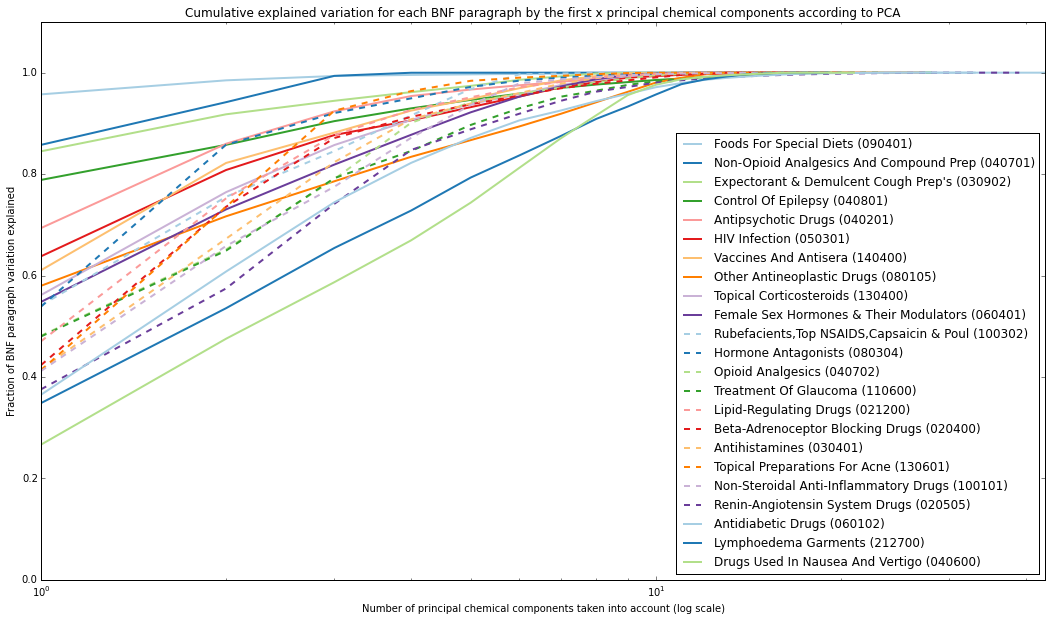

In [12]:
from sklearn.decomposition import PCA
evrlist=list() # list to hold a data frame for each paragraph, which will then get concatanated to produce single dataframe of the final results
for parag in fracs.index.levels[0]:
    crosstab=fracs.ix[parag].unstack(0).fillna(0)
    pca=PCA()
    pca.fit_transform(crosstab)
    parag_evr=pd.DataFrame(pca.explained_variance_ratio_,columns=['EVR'])
    parag_evr.index=parag_evr.index.map(lambda i:i+1)
    evrlist.append(parag_evr)
    
evr=pd.concat(evrlist,keys=fracs.index.levels[0])
evr.index=evr.index.swaplevel(0,1) # makes it easier to find variance explained by more significant component
colors='#a6cee3,#1f78b4,#b2df8a,#33a02c,#fb9a99,#e31a1c,#fdbf6f,#ff7f00,#cab2d6,#6a3d9a'.split(',')
style=['-']*len(colors)+['--']*len(colors)
evr_unstacked=evr.unstack(1)['EVR'][evr.ix[1].sort(columns='EVR',ascending=False).index].cumsum()
ax=evr_unstacked.plot(logx=True,figsize=(18,10),linewidth=2,color=colors,style=style,ylim=0,legend=True,
                      title='Cumulative explained variation for each BNF paragraph by the first x principal chemical components according to PCA')
ax.set_xlabel("Number of principal chemical components taken into account (log scale)")
ax.set_ylabel("Fraction of BNF paragraph variation explained")

## Principal component constitution

Let's look at the concrete principal components of the paragraphs. These are combinations of the chemicals that are most aligned to the axes of variance of the paragraph.

I list the first few for each paragrap, with the chapters in descending order of "simplicity".

I'm reporting the first 3 principal components for each chapter; and for each principal component I list the chemical constituents with weight above 10%.

In [13]:
def describe_principal_components(parag,ncts=3,minw=0.1):
    print parag,"\n"
    crosstab=fracs.ix[parag].unstack(0).fillna(0)
    pca=PCA()
    pca.fit(crosstab)
    for i,princomp in enumerate(range(ncts)):
        print "\tPrincipal component %i - explains %.2f%% of the variance:\n" % (princomp,100*pca.explained_variance_ratio_[i])
        
        chems=list()
        for i,w in enumerate(pca.components_[princomp]):

            if abs(w)>minw:
                chems.append((abs(w),w,"%s (%s)" % (bnf.path(crosstab.columns[i][1])[-1],crosstab.columns[i][1])))
        for a,w,c in sorted(chems,reverse=True):
            print "\t\t%s: %s" % (c,w)
        print
       
for ch in evr.ix[1].sort(columns='EVR',ascending=False).index:
    describe_principal_components(ch,ncts=3,minw=0.1)
    print "="*80

Foods For Special Diets (090401) 

	Principal component 0 - explains 95.72% of the variance:

		Other Food For Special Diet Preps (090401000): -0.850830710212
		Gluten Free Bread (0904010H0): 0.495510423244
		Gluten Free Mixes (090401030): 0.144654854616

	Principal component 1 - explains 2.77% of the variance:

		Gluten Free Bread (0904010H0): 0.787610958495
		Gluten Free Mixes (090401030): -0.365109516839
		Other Food For Special Diet Preps (090401000): 0.358314097532
		Gluten Free/Wheat Free Pasta (090401080): -0.270014919388
		Gluten Free/Wheat Free Bread (0904010U0): -0.146581467094

	Principal component 2 - explains 0.86% of the variance:

		Gluten Free Mixes (090401030): 0.856255796543
		Gluten Free/Wheat Free Bread (0904010U0): -0.293979911362
		Gluten Free/Wheat Free Biscuits (0904010A0): -0.199797009431
		Gluten Free/Wheat Free Cereals (0904010AC): -0.196971868802
		Other Food For Special Diet Preps (090401000): 0.187646121148
		Gluten Free/Wheat Free Pasta (090401080): -0.16